##Importing Required Libraries

In [12]:
!pip install colorama
import seaborn as sns
import matplotlib.pyplot as plt
import time
import sys
import os

## Modified Reward for Better Results

In [13]:
import random
import pprint
import io
import numpy as np
import sys
from gym.envs.toy_text import discrete
from colorama import Fore, Back, Style

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class GridworldEnv(discrete.DiscreteEnv):
  metadata = {'render.modes': ['human', 'ansi']}

  def __init__(self, shape=[10,10]):
    if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
        raise ValueError('shape argument must be a list/tuple of length 2')
        
    self.shape = shape

    nS = np.prod(shape)
    nA = 4

    MAX_Y = shape[0]
    MAX_X = shape[1]

    P = {}
    grid = np.arange(nS).reshape(shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      # P[s][a] = (prob, next_state, reward, is_done)
      P[s] = {a : [] for a in range(nA)}

      #Reaching target
      is_done = lambda s: s == 0

      #Due to existance of walls, these moves are not available
      no_up = lambda s: s in [44,45,63,64]
      no_down = lambda s: s in [23,24,25,44]
      no_left = lambda s: s in [44,36,55]
      no_right = lambda s: s in [32,42,52]

      #Barries in the path
      pit = lambda s: s in [13,62,41]
      wall = lambda s: s in [43,33,53,34,35,54]

      #Rewards of each state
      reward = 20.0 if is_done(s) else -1.0
      reward = -10.0 if pit(s) else reward
      
      ns_up = s if y == 0 else s - MAX_X
      ns_right = s if x == (MAX_X - 1) else s + 1
      ns_down = s if y == (MAX_Y - 1) else s + MAX_X
      ns_left = s if x == 0 else s - 1
      
      P[s][UP] = [(1, ns_up, reward, is_done(ns_up))]
      P[s][RIGHT] = [(1.0, ns_right, reward, is_done(ns_right))]
      P[s][DOWN] = [(1, ns_down, reward, is_done(ns_down))]
      P[s][LEFT] = [(1, ns_left, reward, is_done(ns_left))]

      #Terminal state
      if is_done(s):
        P[s][UP] = [(1.0, s, reward, True)]
        P[s][RIGHT] = [(1.0, s, reward, True)]
        P[s][DOWN] = [(1.0, s, reward, True)]
        P[s][LEFT] = [(1.0, s, reward, True)]

      #Encountering walls
      if no_up(s):
        P[s][UP] = [(1.0, s, -3.0 , False)]                
      if no_down(s):
        P[s][DOWN] = [(1.0, s, -3.0 , False)]                
      if no_right(s):
        P[s][RIGHT] = [(1.0, s, -3.0 , False)]  
      if no_left(s):
        P[s][LEFT] = [(1.0, s, -3.0 , False)] 

      it.iternext() 

    # Initial state distribution is uniform
    isd = np.zeros(100)
    isd[44]=1
    self.P = P

    super(GridworldEnv, self).__init__(nS, nA, P, isd)

  def _render(self, mode='human', close=False):
    if close:
      return

    outfile = io.StringIO() if mode == 'ansi' else sys.stdout

    grid = np.arange(self.nS).reshape(self.shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      if self.s == s and not s==0:
        output =  Back.CYAN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL if s not in [13,62,41] else Back.BLUE + Style.BRIGHT + Fore.WHITE + "  웃 " + Style.RESET_ALL
      elif s == 0:
          output = Back.GREEN + Style.BRIGHT + Fore.WHITE + "     " + Style.RESET_ALL if not self.s==0 else Back.GREEN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL
      elif s in [13,62,41]:
          output = Back.BLUE + "     " + Style.RESET_ALL
      elif s in [43,33,53,34,35,54]:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +   "  █  "  + Style.RESET_ALL
      else:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +  "  .  " + Style.RESET_ALL

      if x == 0:
          output = output.lstrip()
      if x == self.shape[1] - 1:
          output = output.rstrip()

      outfile.write(output)

      if x == self.shape[1] - 1:
          outfile.write("\n")

      it.iternext()

## 2-Step Expected SARSA 
*with modified reward*


0

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

90

91

92

93

94

95

96

97

98

99

100

101

102

103

104

105

106

107

108

109

110


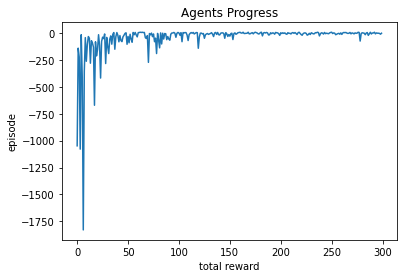

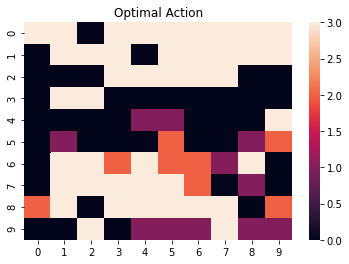

[[3 3 0 3 3 3 3 3 3 3]
 [0 3 3 3 0 3 3 3 3 3]
 [0 0 0 3 3 3 3 3 0 0]
 [0 3 3 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 3]
 [0 1 0 0 0 2 0 0 1 2]
 [0 3 3 2 3 2 2 1 3 0]
 [0 3 3 3 3 3 2 0 1 0]
 [2 3 0 3 3 3 3 3 0 2]
 [0 0 3 0 1 1 1 3 1 1]]
Total execution Time:  0.07663785219192505 Min


In [14]:
class NStepSARSA:
    def __init__(self,environment,n = 2,discount_factor = 1.0, learning_rate = 0.2, epsilon = 1.0):
        self.gamma = discount_factor
        self.alpha = learning_rate
        self.epsilon = epsilon
        self.env = environment
        self.n = n # n-step SARSA

        self.Q = np.zeros((self.env.nS,self.env.nA))

    def behaviour(self,state):
        # Behaviour policy is an epsilon greedy policy with constant epsilon
        epsilon = self.epsilon
        res = np.ones(self.env.nA, dtype = np.float64) * (epsilon / self.env.nA)
        res[np.argmax(self.Q[state])] += 1.0 - epsilon
        return res
    
    def target(self, state):
        # Behaviour policy is an epsilon greedy policy too but woth smaller epsilon
        epsilon = self.epsilon 
        res = np.ones(self.env.nA, dtype = np.float64) * (epsilon / self.env.nA)
        res[np.argmax(self.Q[state])] += 1.0 - epsilon
        return res
    
    def run(self, episode_number):

        reward_per_episode = [0] * episode_number

        for num_episode in range(episode_number):
            print('\b' * 5)
            print(num_episode)

            state = self.env.reset()
            T = sys.maxsize
            t = -1

            actions = {}    # Dictionary for storing next n-step actions
            states = {}     # Dictionary for storing next n-step states
            rewards = {}    # Dictionary for storing next n-step rewards

            A0 = np.random.choice(np.arange(self.env.nA), p=self.behaviour(state)) 
            actions[0] = A0
            states[0] = state

            tau = 0
            while  tau < (T-1):
                t += 1
                if t < T:
                    #print('checking next step')
                    state, reward, done, info = self.env.step(A0)

                    reward_per_episode[num_episode] += reward
                    rewards[(t+1) % (self.n+1)] = reward
                    states[(t+1) % (self.n+1)] = state

                    if done:
                        # doing next action to collect reward
                        t+= 1
                        if t < T:
                            #print('checking final step')
                            # Take one more action to collect reward
                            state, reward, done, info = self.env.step(A0)

                            reward_per_episode[num_episode] += reward
                            rewards[(t+1) % (self.n+1)] = reward
                            states[(t+1) % (self.n+1)] = state

                        T = t + 1
                        #print('episode done')
                    else:
                        #print('episode not done')
                        A0 = np.random.choice(np.arange(self.env.nA),p=self.behaviour(state))
                        actions[(t+1) % (self.n+1)] = A0

                tau = t - self.n + 1
                if tau >= 0:
                    #print('updating....')
                    rho = np.prod([self.target(states[i%(self.n+1)])[actions[i%(self.n+1)]]/(self.behaviour(states[i%(self.n+1)])[actions[i%(self.n+1)]]) for i in range(tau+1, min(tau+self.n-1, T-1)+1)])
                    
                    G = np.sum([(self.gamma**(i-tau-1))*rewards[i%(self.n+1)] for i in range(tau+1, min(tau+self.n, T)+1)])

                    if (tau + self.n) < T:
                        G += np.sum( [(self.gamma**self.n) * self.target(states[(tau+self.n)%(self.n+1)])[action] * self.Q[states[(tau+self.n)%(self.n+1)]][action] for action in range(self.env.nA)] )

                    self.Q[states[tau % (self.n+1)]][actions[tau % (self.n+1)]] += self.alpha * rho * (G - self.Q[states[tau % (self.n+1)]][actions[tau % (self.n+1)]])
            
            self.epsilon *= 0.995 # Uncoment for decaying epsilon

        self.plot_agent(reward_per_episode)
        return reward_per_episode
    
    def plot_agent(self, episode_reward):
        %matplotlib inline
        plt.plot(episode_reward)
        plt.title('Agents Progress')
        plt.ylabel("episode")
        plt.xlabel('total reward')
        plt.show()

        ax2 = sns.heatmap(np.argmax(self.Q,axis=1).reshape((10,10)))
        ax2.set_title("Optimal Action")
        plt.show()
        print(np.argmax(self.Q,axis=1).reshape((10,10))) 

    def __exit__(self):
        self.env.close()


env =  GridworldEnv()
agent5 = NStepSARSA(env, n=2)
start_time = time.time()
reward_hist5 = agent5.run(300)                 
print('Total execution Time: ', (time.time() - start_time)/60, 'Min')


## 5 Level Tree backup with modified rewards


0

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

90

91

92

93

94

95

96

97

98

99

100

101

102

103

104

105

106

107

108

109

110


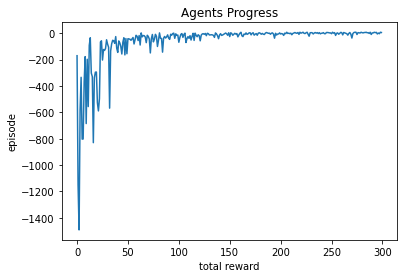

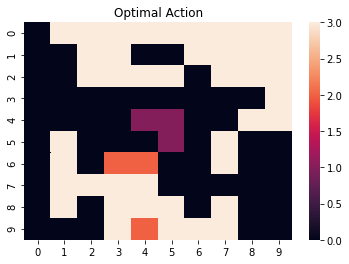

[[0 3 3 3 3 3 3 3 3 3]
 [0 0 3 3 0 0 3 3 3 3]
 [0 0 3 3 3 3 0 3 3 3]
 [0 0 0 0 0 0 0 0 0 3]
 [0 0 0 0 1 1 0 0 3 3]
 [0 3 0 0 0 1 0 3 0 0]
 [0 3 0 2 2 0 0 3 0 0]
 [0 3 3 3 3 0 0 0 0 0]
 [0 3 0 3 3 3 0 3 0 0]
 [0 0 0 3 2 3 3 3 0 0]]
Total execution Time:  0.21481260855992634 Min


In [ ]:
class TBAgent:
    def __init__(self,environment, n, discount_factor = 0.9, learning_rate = 0.5, epsilon = 1.0):
        self.n = n
        self.epsilon = epsilon
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.env = environment

        self.Q = np.zeros((self.env.nS,self.env.nA))

    def behavior(self,state, epsilon = 0.3):
        # Behaviour policy is an epsilon greedy policy with constant epsilon
        res = np.ones(self.env.nA, dtype = np.float64) * (self.epsilon / self.env.nA)
        res[np.argmax(self.Q[state])] += 1.0 - self.epsilon
        return res
    
    def target(self, state):
        # Behaviour policy is an epsilon greedy policy too but woth smaller epsilon
        epsilon = self.epsilon / 3
        res = np.ones(self.env.nA, dtype = np.float64) * (epsilon / self.env.nA)
        res[np.argmax(self.Q[state])] += 1.0 - epsilon
        return res
    
    def run(self,episode_number):
        
        reward_per_episode = [0] * episode_number

        for num_episode in range(episode_number):
            print('\b'*5)
            print(num_episode)
            T = sys.maxsize
            t = -1
            tau = 0

            actions = {}
            rewards = {}
            states = {}

            state = self.env.reset()
            A0 = np.random.choice(np.arange(self.env.nA), p= self.behavior(state))
            actions[0] = A0
            states[0] = state

            #print('.......')
            while tau < (T-1):
                t +=1
                if t < T:
                    state, reward, done, info = self.env.step(A0)

                    reward_per_episode[num_episode] += reward 

                    rewards[(t+1) % (self.n+1)] = reward
                    states[(t+1) % (self.n+1)] = state

                    if done: 
                        t +=1
                        if t < T:
                            state, reward, done, info = self.env.step(A0)

                            reward_per_episode[num_episode] += reward 

                            rewards[(t+1) % (self.n+1)] = reward
                            states[(t+1) % (self.n+1)] = state

                        T = t + 1
                    else:
                        A0 = np.random.choice(np.arange(self.env.nA),p=self.behavior(state))
                        actions[(t+1) % (self.n+1)] = A0

                #print('.......')
                tau = t - self.n + 1
                if tau >= 0:
                    if (t+1) >= T:
                        G = rewards[T % (self.n+1)]
                    else:                        
                        sigma = np.sum([(self.target(states[(t+1) % (self.n+1)])[i]) * self.Q[states[(t+1) % (self.n+1)]][i] for i in range(self.env.nA)])
                        G = rewards[(t+1) % (self.n+1)] + self.gamma * sigma
                    
                    for i in range(min(t, T-1), tau , -1):
                        prob = np.sum([ self.target(states[i%(self.n+1)])[j] * self.Q[states[i%(self.n+1)]][j] for j in range(self.env.nA) if j != actions[i%(self.n+1)] ])
                        G = rewards[i%(self.n+1)] + self.gamma * (prob + self.target(states[i%(self.n+1)])[actions[i%(self.n+1)]]* G)   

                    self.Q[states[tau % (self.n+1)]][actions[tau % (self.n+1)]] += self.alpha * (G - self.Q[states[tau % (self.n+1)]][actions[tau % (self.n+1)]])
            
            self.epsilon *= 0.995 # Uncoment for decaying epsilon
        
        self.plot_agent(reward_per_episode)
        return reward_per_episode

    def plot_agent(self,episode_reward):
        %matplotlib inline
        plt.plot(episode_reward)
        plt.title('Agents Progress')
        plt.ylabel("episode")
        plt.xlabel('total reward')
        plt.show()

        ax2 = sns.heatmap(np.argmax(self.Q,axis=1).reshape((10,10)))
        ax2.set_title("Optimal Action")
        plt.show()
        print(np.argmax(self.Q,axis=1).reshape((10,10))) 
        pass

    def __exit__(self):
        self.env.close()


env = GridworldEnv()
agent6 = TBAgent(env, n= 5)
start_time = time.time()
reward_hist6 = agent6.run(300)
print('Total execution Time: ', (time.time() - start_time)/60, 'Min')

## SARSA in Modified Environment

0

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

90

91

92

93

94

95

96

97

98

99

100

101

102

103

104

105

106

107

108

109

110



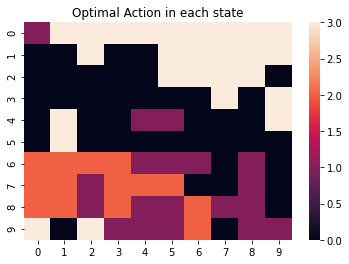

[[1 3 3 3 3 3 3 3 3 3]
 [0 0 3 0 0 3 3 3 3 3]
 [0 0 0 0 0 3 3 3 3 0]
 [0 0 0 0 0 0 0 3 0 3]
 [0 3 0 0 1 1 0 0 0 3]
 [0 3 0 0 0 0 0 0 0 0]
 [2 2 2 2 1 1 1 0 1 0]
 [2 2 1 2 2 2 0 0 1 0]
 [2 2 1 2 1 1 2 1 1 0]
 [3 0 3 1 1 1 2 0 1 1]]


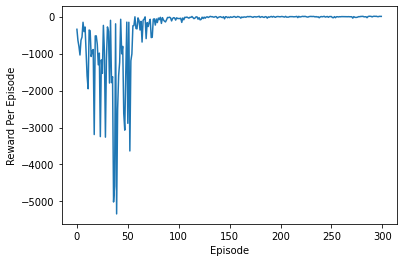

In [ ]:
class SARSA:
    def __init__(self, environment, discount_factor = 0.9, epsilon = 1.0, learning_rate = 0.5):
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.env = environment
        self.epsilon = epsilon
        
        self.Q = np.zeros((self.env.nS,self.env.nA))
        self.state = self.env.reset()

    def e_greedy(self,values):
        # Calculating Probability of each action in a state out of action values
        # This Function will be used for epsilon greedy decision making in control
        res = np.ones(self.env.nA, dtype = np.float64) * (self.epsilon / self.env.nA)
        res[np.argmax(values)] += 1.0 - self.epsilon
        return res
    
    def control(self):
        start = time.time() # start time to avoid extra long episodes
        reward_sum = 0
        # Choosing an Action Based On Epsilon Greedy Policy
        action = np.random.choice(np.arange(self.env.nA), p=self.e_greedy(self.Q[self.state]))
        # Loop for single episode
        while True:
            
            next_state, reward, done, info = self.env.step(action)
            reward_sum += reward

            next_action = np.random.choice(np.arange(self.env.nA),p=self.e_greedy(self.Q[next_state]))
            
            # Temporal Difference Update
            self.Q[self.state][action] += self.alpha * (reward + self.gamma * self.Q[next_state][next_action] -self.Q[self.state][action])
            
            self.state = next_state
            action = next_action

            if done:
                next_state, reward, done, info = self.env.step(action)
                reward_sum += reward
                next_action = np.random.choice(np.arange(self.env.nA),p=self.e_greedy(self.Q[next_state]))
                self.Q[self.state][action] += self.alpha * (reward + self.gamma * self.Q[next_state][next_action] -self.Q[self.state][action])
                
                self.state = self.env.reset()
                break

            #if time.time() - start > 3: break 
        return reward_sum

    def print_agent(self):
        ax = sns.heatmap(np.argmax(self.Q,axis=1).reshape((10,10)))
        ax.set_title("Optimal Action in each state")
        plt.show()
        print(np.argmax(self.Q,axis=1).reshape((10,10)))

    def __exit__(self):
        self.env.close()

env = GridworldEnv()
agent3 = SARSA(env)
reward_hist3 = list('')
start_time = time.time()
for _ in range(300):
    print(_)
    reward_hist3.append(agent3.control())
    agent3.epsilon *= 0.995
    print('\b' * 5)

print('Total Execution Time: ', (time.time() - start_time)/60 , 'Min')
agent3.print_agent()
%matplotlib inline
plt.plot(reward_hist3)
plt.ylabel('Reward Per Episode')
plt.xlabel('Episode')
plt.show()